In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.manifold import TSNE

# --- 1. CONFIGURAÇÕES VISUAIS ---
# Estilo acadêmico limpo
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'figure.dpi': 300,        # Alta resolução para o PDF/LaTeX
    'savefig.dpi': 300,
    'font.family': 'sans-serif' # Ou 'serif' se preferir estilo LaTeX clássico
})

# --- 2. CAMINHOS ---
BASE_DIR = Path("/Users/lucasborges/Downloads/TCC")

# Arquivos necessários
TRACKS_META_PATH = BASE_DIR / "data/interim/df_tracks_complete_v5.parquet"
SUPER_EMB_PATH   = BASE_DIR / "graphs/super_item_item/super_embeddings_mean.parquet"
METRICS_PATH     = BASE_DIR / "reports/cold_start_metrics_per_playlist.parquet" # O arquivo que sugeri salvar acima

# --- 3. CARREGAMENTO ---
print("Carregando dados para visualização...")

# A. Metadados (Para Figura 1 - Cauda Longa)
try:
    print(f"📄 Carregando Metadados: {TRACKS_META_PATH.name}...")
    df_tracks = pd.read_parquet(TRACKS_META_PATH)
    print(f"   ✓ {len(df_tracks):,} faixas carregadas.")
except FileNotFoundError:
    print(f"   ❌ Arquivo não encontrado: {TRACKS_META_PATH}")

# B. Embeddings Super-Nós (Para Figura 2 - t-SNE)
try:
    print(f"🧠 Carregando Embeddings: {SUPER_EMB_PATH.name}...")
    df_super_emb = pd.read_parquet(SUPER_EMB_PATH)
    # Separar matriz Z
    emb_cols = [c for c in df_super_emb.columns if c.startswith("emb_mean_")]
    Z_super = df_super_emb[emb_cols].to_numpy()
    print(f"   ✓ Matriz Z shape: {Z_super.shape}")
except FileNotFoundError:
    print(f"   ❌ Arquivo não encontrado: {SUPER_EMB_PATH}")

# C. Métricas Detalhadas (Para Figura 4 - Histograma)
# Se você não salvou este arquivo, precisaremos pular a Figura 4 ou usar dados dummy
try:
    print(f"📊 Carregando Métricas: {METRICS_PATH.name}...")
    df_metrics = pd.read_parquet(METRICS_PATH)
    print(f"   ✓ Dados de {len(df_metrics):,} playlists carregados.")
except FileNotFoundError:
    print(f"   ⚠️ Arquivo de métricas não encontrado ({METRICS_PATH.name}).")
    print("      (Você precisará rodar a avaliação e salvar o df_results para gerar o histograma real).")

print("\nSetup concluído! Pronto para gerar figuras.")

Carregando dados para visualização...
📄 Carregando Metadados: df_tracks_complete_v5.parquet...
   ✓ 3,636,571 faixas carregadas.
🧠 Carregando Embeddings: super_embeddings_mean.parquet...
   ✓ Matriz Z shape: (20047, 64)
📊 Carregando Métricas: cold_start_metrics_per_playlist.parquet...
   ✓ Dados de 54,155 playlists carregados.

Setup concluído! Pronto para gerar figuras.


Gerando Figura 1: Distribuição de Popularidade...


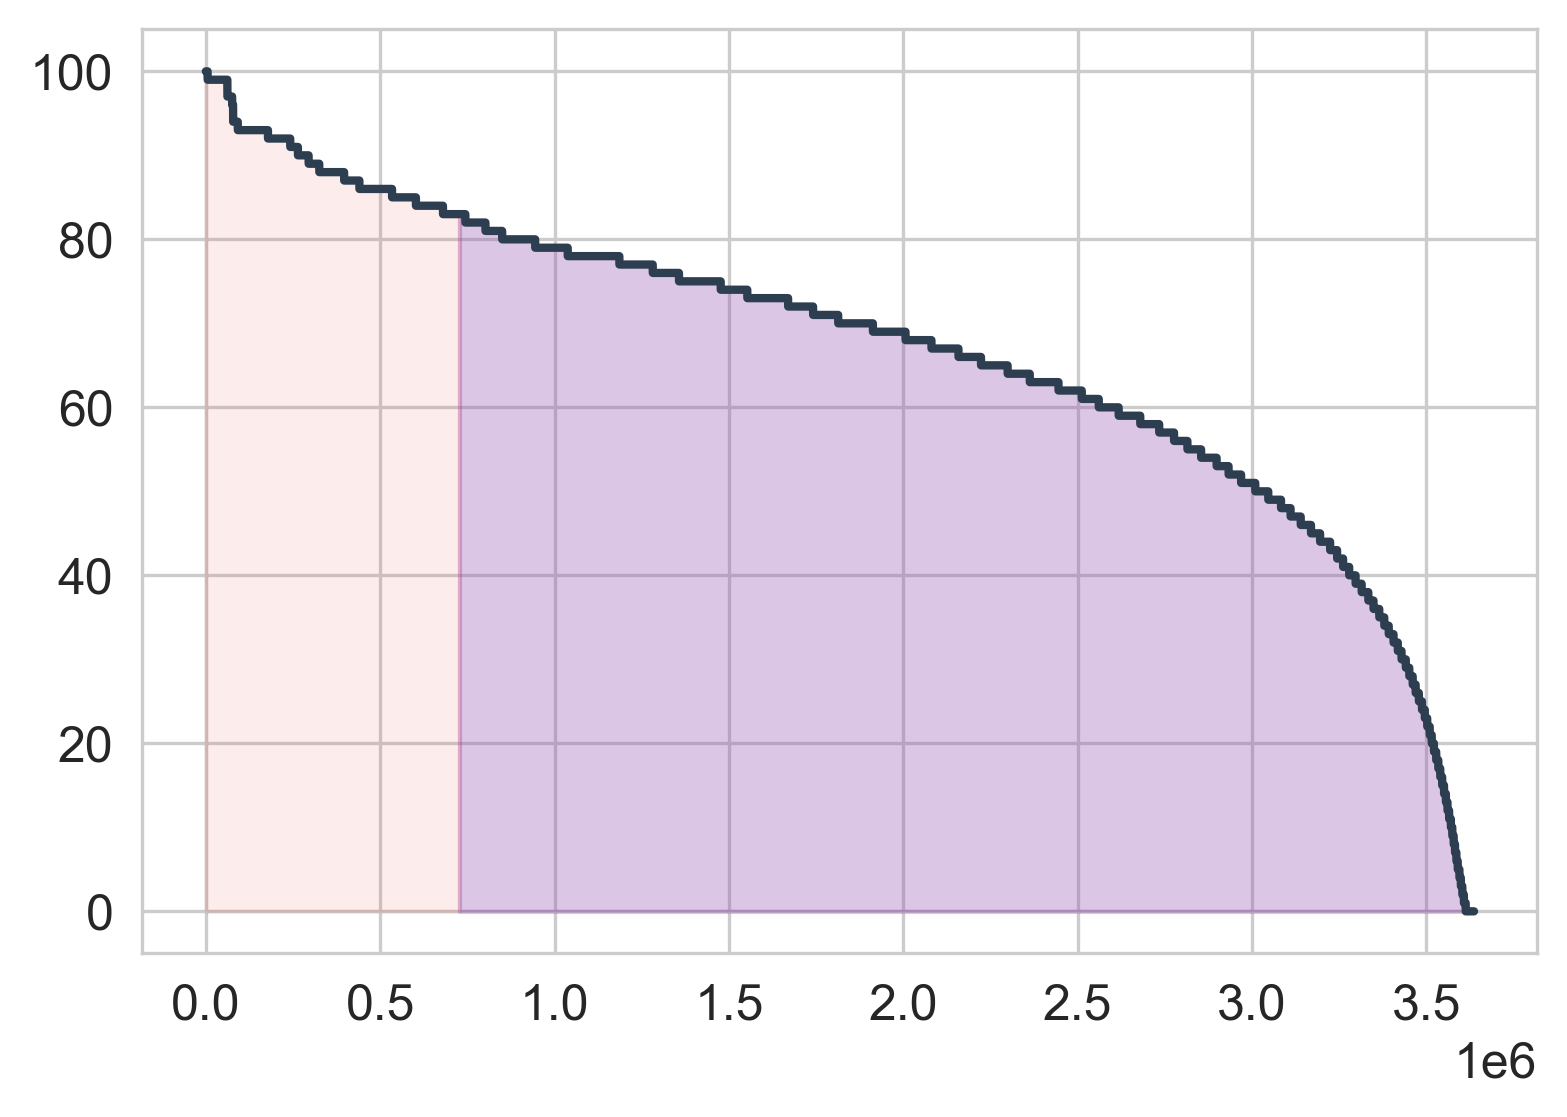

In [9]:
# Criar diretório de saída
OUT_FIG_DIR = BASE_DIR / "reports/figures"
OUT_FIG_DIR.mkdir(parents=True, exist_ok=True)

def plot_long_tail(df, save_name="fig1_long_tail.pdf"):
    print("Gerando Figura 1: Distribuição de Popularidade...")
    
    # Vamos usar 'artist_popularity' como proxy de popularidade da faixa
    # (ou contagem de playlists se você tiver essa coluna calculada)
    if 'artist_popularity' in df.columns:
        metric = 'artist_popularity'
        ylabel = "Popularidade do Artista"
    else:
        # Fallback fictício se não tiver a coluna, apenas para não quebrar
        print("Aviso: Coluna de popularidade não encontrada, usando índice.")
        metric = df.index
        ylabel = "Interações"

    # Ordenar (Do mais popular para o menos)
    pop_values = df[metric].sort_values(ascending=False).reset_index(drop=True)
    
    plt.figure(figsize=(6, 4))
    
    # Plotar a linha
    plt.plot(pop_values, color='#2c3e50', linewidth=2, label='Popularidade')
    
    # Preencher a Cauda Longa
    head_cutoff = int(len(pop_values) * 0.2) # Princípio de Pareto (20% Head)
    plt.fill_between(pop_values.index[head_cutoff:], pop_values[head_cutoff:], color='#8e44ad', alpha=0.3, label='Cauda Longa (Nicho)')
    plt.fill_between(pop_values.index[:head_cutoff], pop_values[:head_cutoff], color='#e74c3c', alpha=0.1, label='Head (Populares)')
    
    # # Anotações
    # plt.axvline(x=head_cutoff, color='#e74c3c', linestyle='--', alpha=0.8)
    # plt.text(head_cutoff * 1.1, pop_values.max() * 0.8, 'Divisão Head/Tail', color='#c0392b', rotation=0)

    # plt.title("Distribuição de Popularidade no Dataset (Lei de Potência)", fontsize=14)
    # plt.xlabel("Itens (Ordenados por Popularidade)")
    # plt.ylabel(ylabel)
    # plt.legend()
    # plt.grid(True, alpha=0.2)
    
    # # Salvar
    # save_path = OUT_FIG_DIR / save_name
    # plt.savefig(save_path, bbox_inches='tight')
    # print(f"✓ Salvo em: {save_path.name}")
    plt.show()

# Executar
if 'df_tracks' in globals():
    plot_long_tail(df_tracks)

Gerando Figura 2: t-SNE dos Super-Nós...


/opt/anaconda3/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


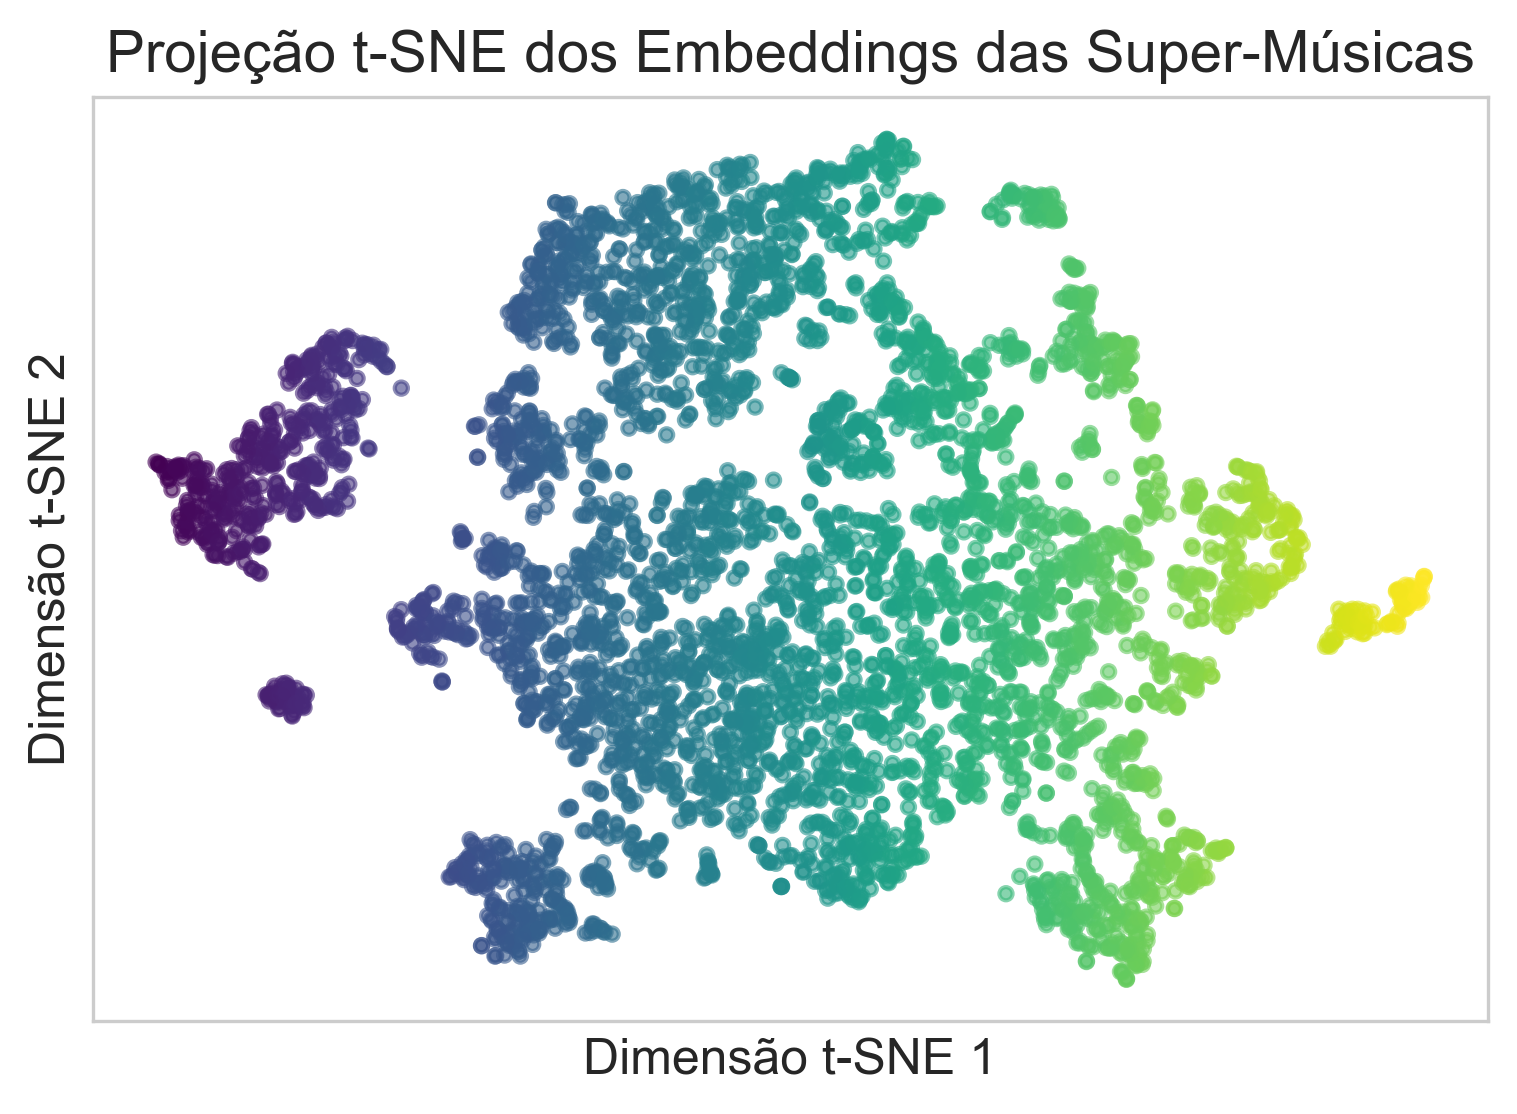

In [10]:
from sklearn.manifold import TSNE

def plot_tsne_supernodes(Z, save_name="fig2_tsne_embeddings.png"):
    print("Gerando Figura 2: t-SNE dos Super-Nós...")
    
    # Amostragem para performance (t-SNE em 20k pontos pode demorar, vamos usar 5k)
    n_samples = 5000
    indices = np.random.choice(len(Z), min(len(Z), n_samples), replace=False)
    Z_sample = Z[indices]
    
    # Executar t-SNE
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42, init='pca', learning_rate='auto')
    Z_2d = tsne.fit_transform(Z_sample)
    
    plt.figure(figsize=(6, 4))
    
    # Scatter plot
    # Usamos c=Z_2d[:, 0] apenas para dar um gradiente de cor visual, 
    # já que não carregamos os gêneros aqui. Se tiver gêneros, use `hue=generos`.
    plt.scatter(Z_2d[:, 0], Z_2d[:, 1], c=Z_2d[:, 0], cmap='viridis', s=10, alpha=0.6)
    
    plt.title("Projeção t-SNE dos Embeddings das Super-Músicas", fontsize=14)
    plt.xlabel("Dimensão t-SNE 1")
    plt.ylabel("Dimensão t-SNE 2")
    
    # Remover eixos numéricos (poluição visual desnecessária para t-SNE)
    plt.xticks([])
    plt.yticks([])
    
    # # Salvar (PNG é melhor para muitos pontos que PDF)
    # save_path = OUT_FIG_DIR / save_name
    # plt.savefig(save_path, dpi=300, bbox_inches='tight')
    # print(f"✓ Salvo em: {save_path.name}")
    plt.show()

# Executar
if 'Z_super' in globals():
    plot_tsne_supernodes(Z_super)

Gerando Figura 3: Curvas de Aprendizado...


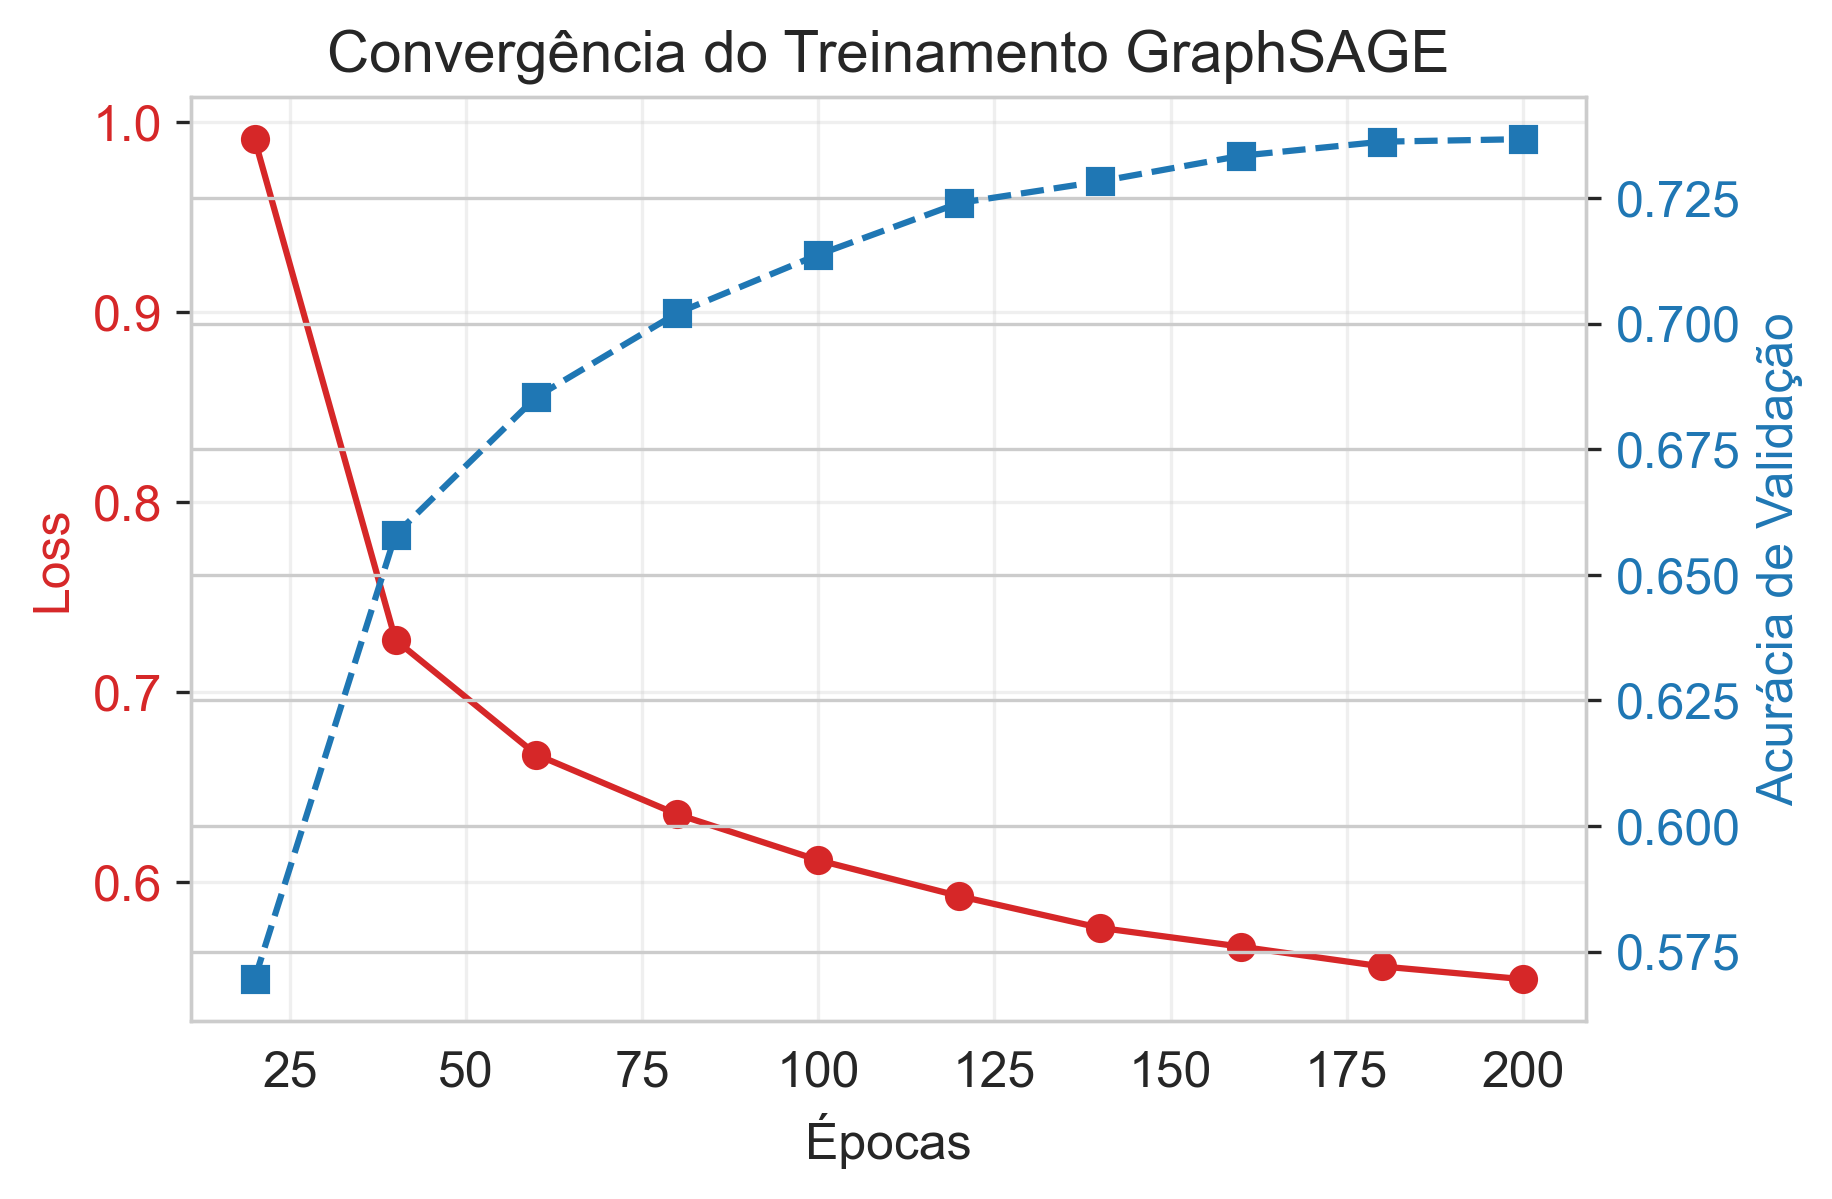

In [11]:
def plot_learning_curves(save_name="fig3_training_curves.pdf"):
    print("Gerando Figura 3: Curvas de Aprendizado...")
    
    # DADOS REAIS extraídos do log (Seed 42)
    epochs = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
    loss = [0.9909, 0.7274, 0.6671, 0.6357, 0.6116, 0.5927, 0.5760, 0.5661, 0.5557, 0.5490]
    val_acc = [0.5695, 0.6580, 0.6854, 0.7021, 0.7137, 0.7240, 0.7283, 0.7334, 0.7362, 0.7367]
    
    fig, ax1 = plt.subplots(figsize=(6, 4))

    # Eixo Esquerdo (Loss)
    color_loss = 'tab:red'
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Loss', color=color_loss, fontsize=12)
    ax1.plot(epochs, loss, color=color_loss, marker='o', label='Loss de Treino')
    ax1.tick_params(axis='y', labelcolor=color_loss)
    ax1.grid(True, alpha=0.3)

    # Eixo Direito (Acurácia)
    ax2 = ax1.twinx() 
    color_acc = 'tab:blue'
    ax2.set_ylabel('Acurácia de Validação', color=color_acc, fontsize=12)
    ax2.plot(epochs, val_acc, color=color_acc, marker='s', linestyle='--', label='Val Acurácia')
    ax2.tick_params(axis='y', labelcolor=color_acc)

    plt.title("Convergência do Treinamento GraphSAGE", fontsize=14)
    
    # # Salvar
    # save_path = OUT_FIG_DIR / save_name
    # plt.savefig(save_path, bbox_inches='tight')
    # print(f"✓ Salvo em: {save_path.name}")
    plt.show()

plot_learning_curves()

Gerando Figura 4: Histograma de Recall...


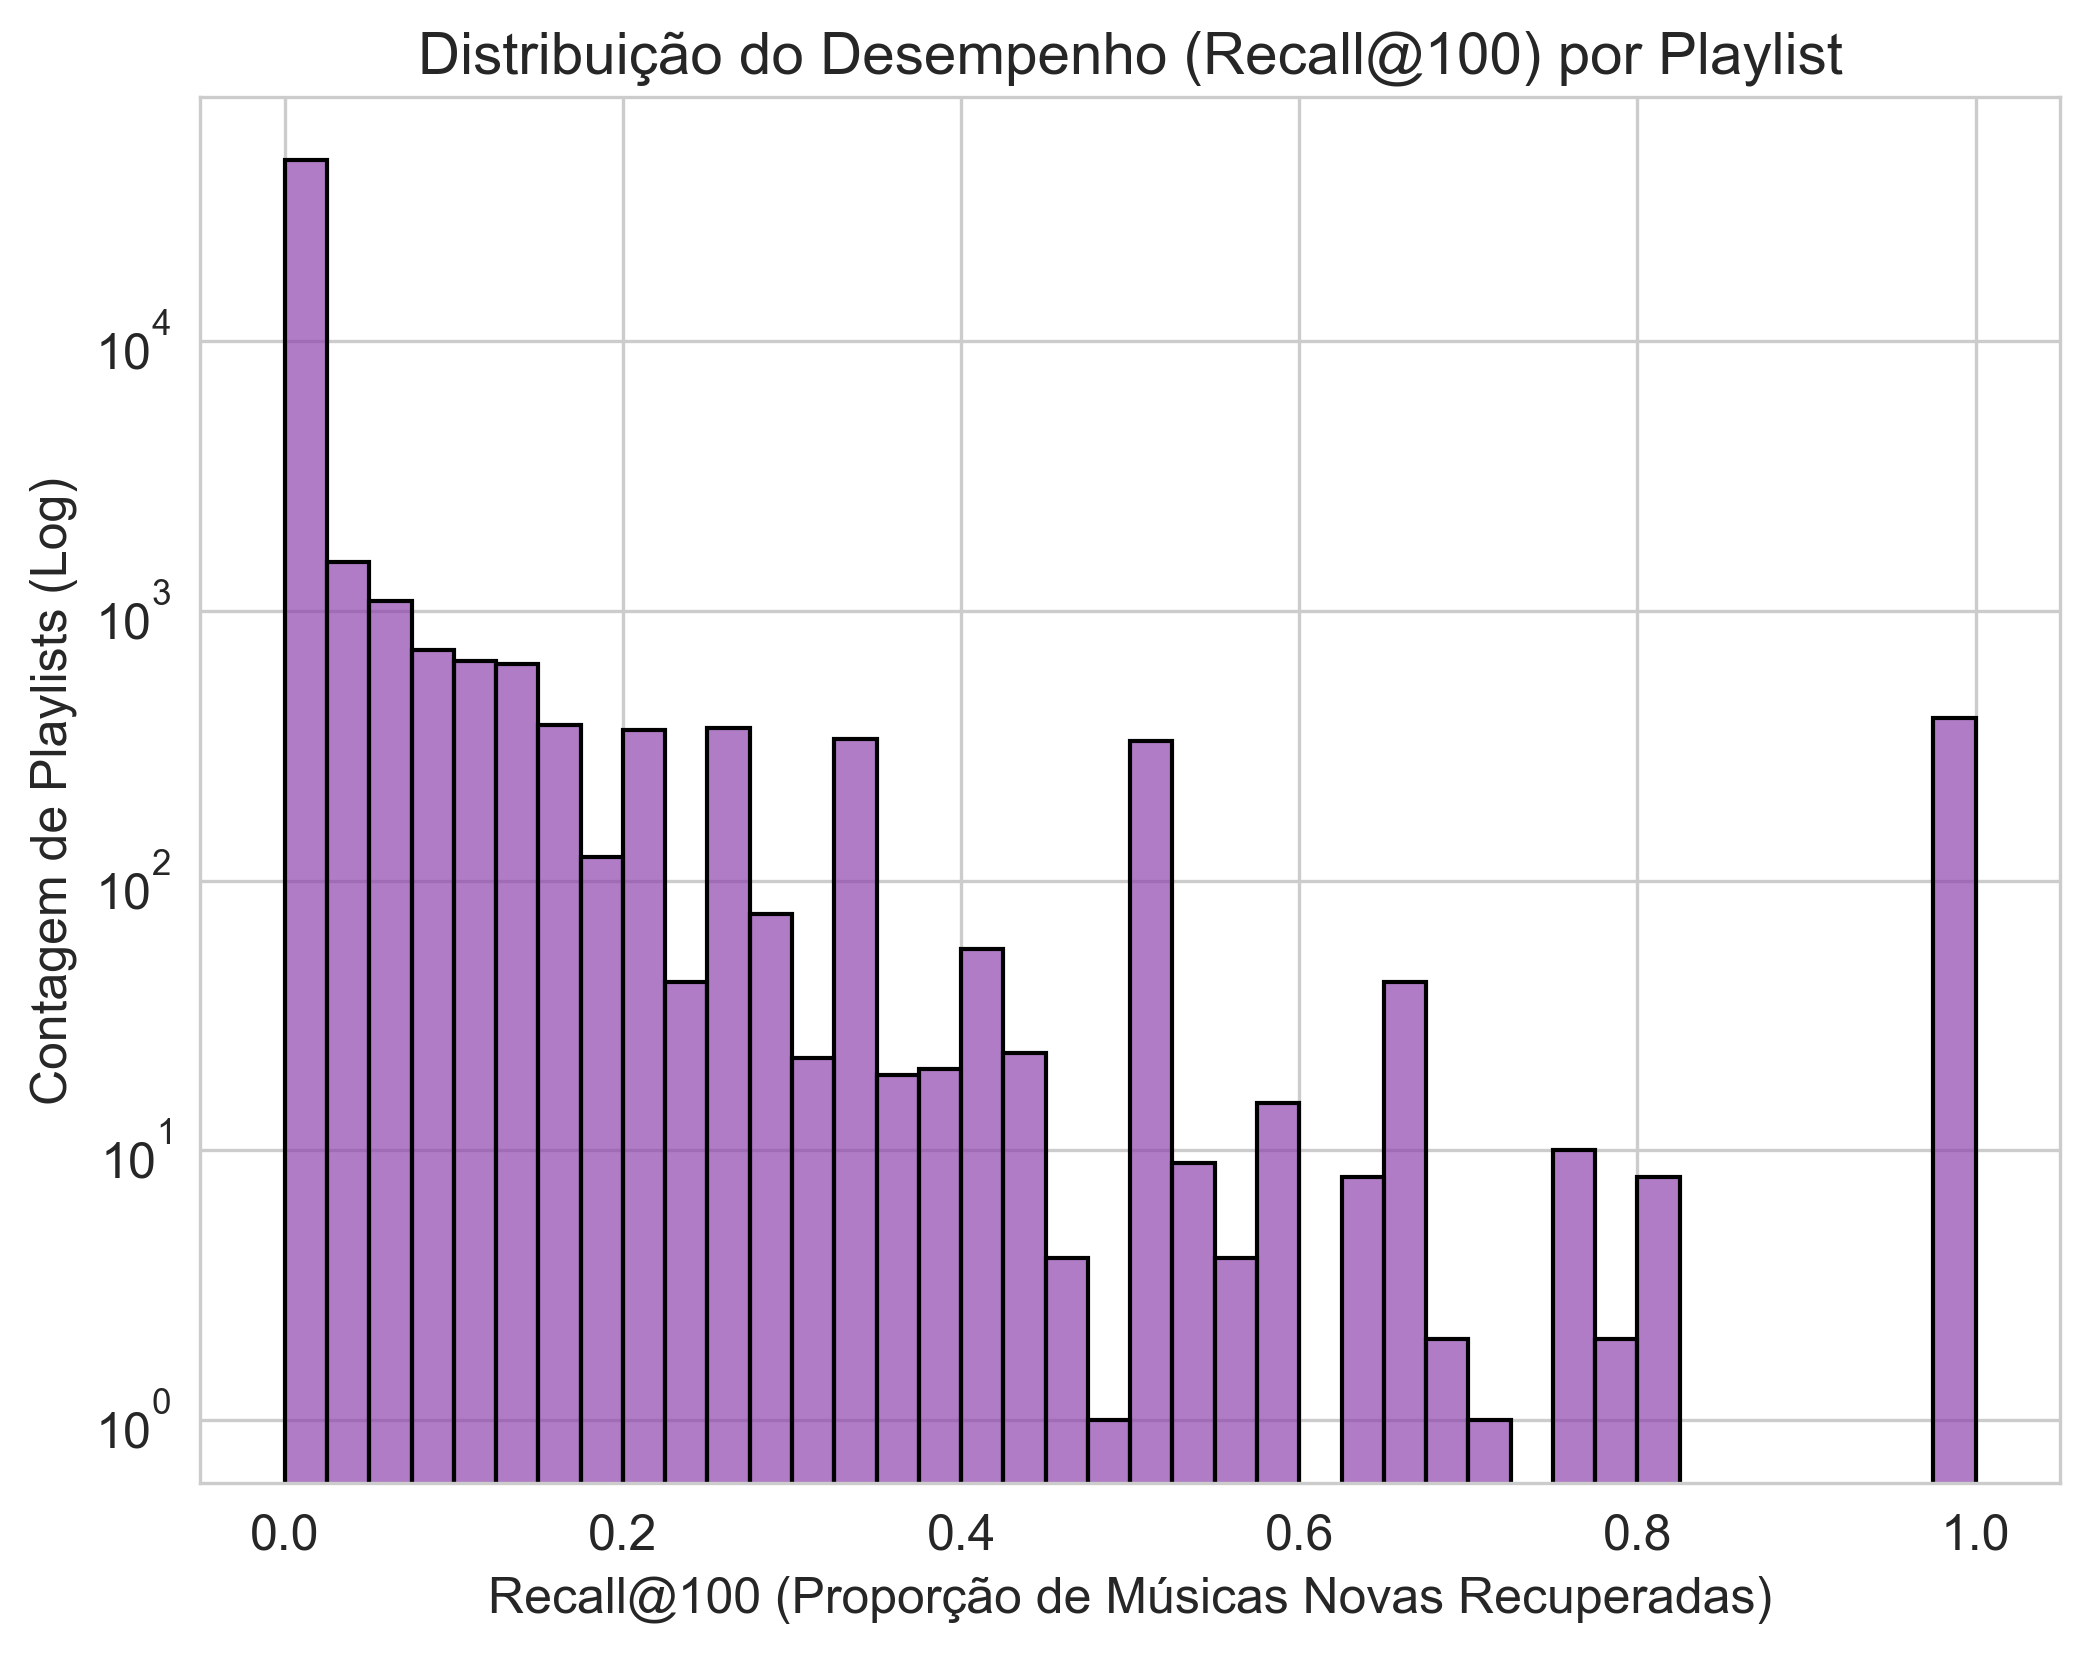

In [12]:
def plot_recall_histogram(df_metrics, save_name="fig4_recall_hist.pdf"):
    print("Gerando Figura 4: Histograma de Recall...")
    
    if df_metrics is None or 'Recall@100' not in df_metrics.columns:
        print("⚠️ Dados de métricas não disponíveis. Pulando Figura 4.")
        return

    plt.figure(figsize=(8, 6))
    
    # Histograma com escala Log
    sns.histplot(
        df_metrics['Recall@100'], 
        bins=40, 
        kde=False, 
        color='#8e44ad', 
        edgecolor='black',
        alpha=0.7
    )
    
    plt.yscale('log') # O segredo para ver a cauda longa
    
    plt.title("Distribuição do Desempenho (Recall@100) por Playlist", fontsize=14)
    plt.xlabel("Recall@100 (Proporção de Músicas Novas Recuperadas)")
    plt.ylabel("Contagem de Playlists (Log)")
    
    # # Anotação explicando o "Hit or Miss"
    # plt.text(0.6, 100, "Sucessos Totais\n(Recall ≈ 1.0)", fontsize=10, color='green')
    # plt.text(0.02, 20000, "Falhas de Mapeamento\n(Recall ≈ 0)", fontsize=10, color='red')

    # # Salvar
    # save_path = OUT_FIG_DIR / save_name
    # plt.savefig(save_path, bbox_inches='tight')
    # print(f"✓ Salvo em: {save_path.name}")
    plt.show()

# Executar
if 'df_metrics' in globals():
    plot_recall_histogram(df_metrics)

Gerando Figura 5: Comparativo com Baseline...


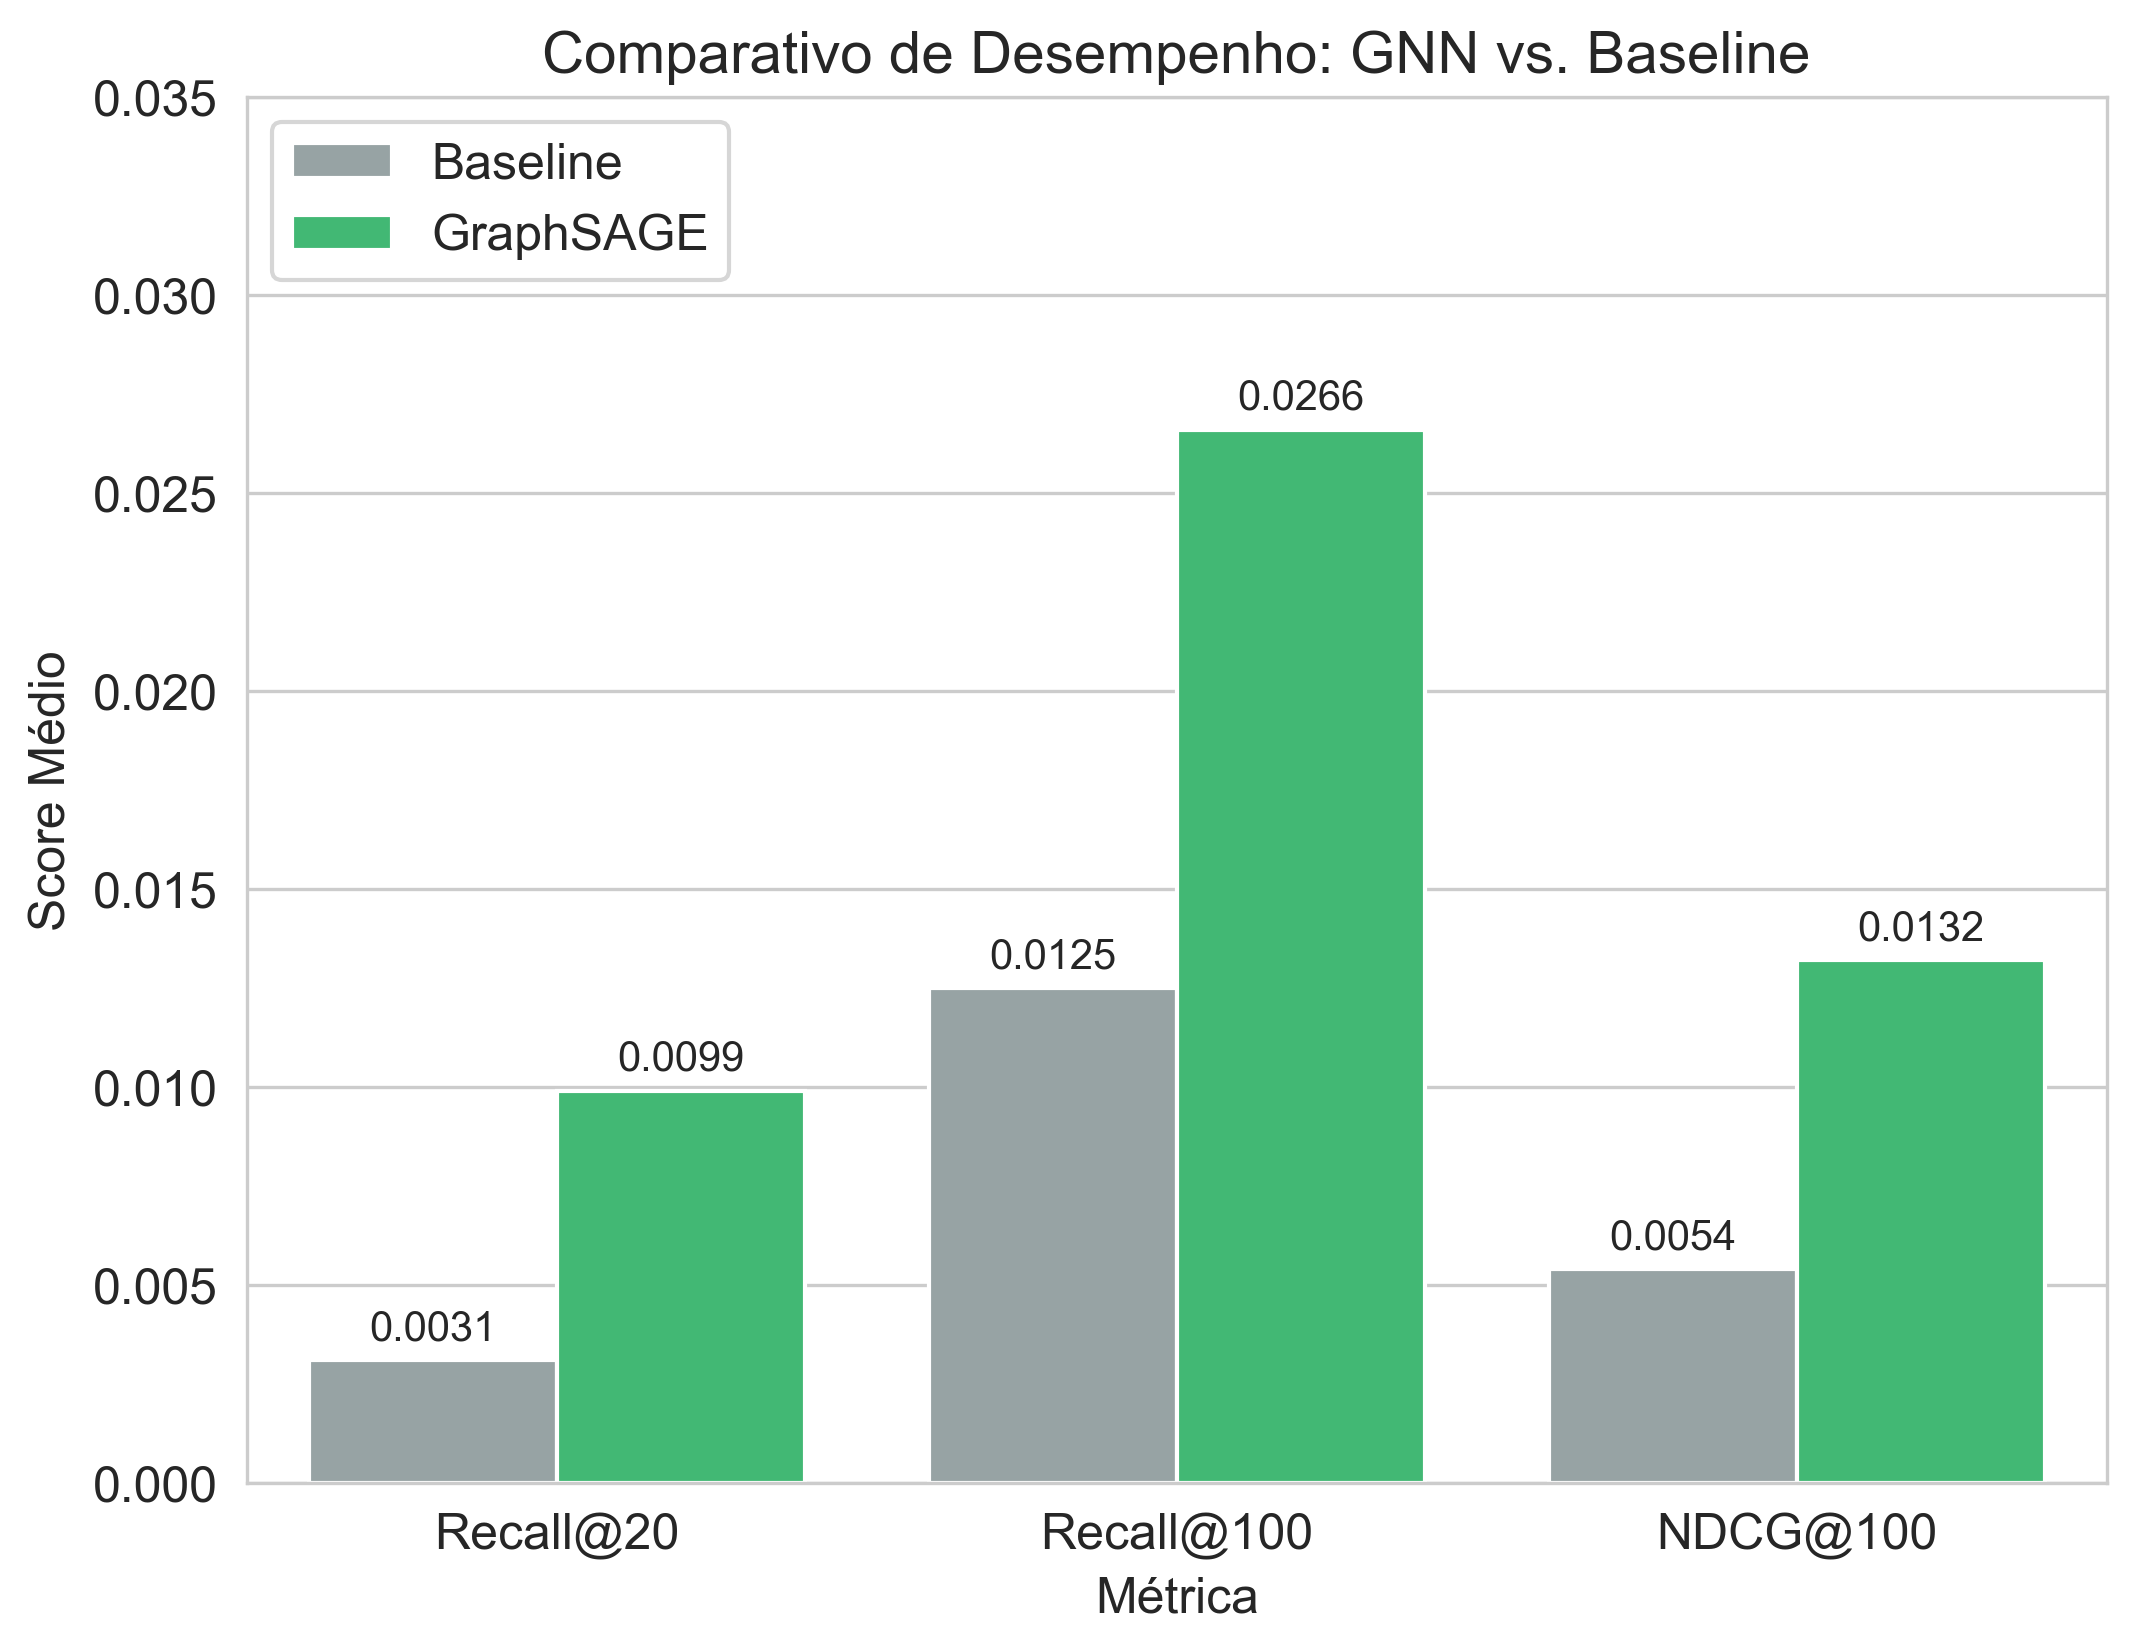

In [13]:
def plot_comparison_chart(save_name="fig5_benchmark.pdf"):
    print("Gerando Figura 5: Comparativo com Baseline...")
    
    # Dados finais que obtivemos
    data = {
        'Métrica': ['Recall@20', 'Recall@20', 'Recall@100', 'Recall@100', 'NDCG@100', 'NDCG@100'],
        'Modelo': ['Baseline', 'GraphSAGE', 'Baseline', 'GraphSAGE', 'Baseline', 'GraphSAGE'],
        'Valor': [0.0031, 0.0099, 0.0125, 0.0266, 0.0054, 0.0132]
    }
    df_comp = pd.DataFrame(data)
    
    plt.figure(figsize=(8, 6))
    
    # Barplot agrupado
    ax = sns.barplot(
        data=df_comp, 
        x='Métrica', 
        y='Valor', 
        hue='Modelo', 
        palette=['#95a5a6', '#2ecc71'] # Cinza para baseline, Verde para o nosso
    )
    
    # Adicionar labels de valor e uplift
    for i, container in enumerate(ax.containers):
        ax.bar_label(container, fmt='%.4f', padding=3, fontsize=10)
    
    # Linhas de anotação de Uplift (Manual para ficar bonito)
    # Exemplo para Recall@100
    # x_coords = [BarraBase, BarraGNN]
    # y_coords = [AlturaBase, AlturaGNN]
    # Isso é difícil de automatizar perfeitamente no matplotlib simples, 
    # então usamos o título ou legenda para destacar.
    
    plt.title("Comparativo de Desempenho: GNN vs. Baseline", fontsize=14)
    plt.ylabel("Score Médio")
    plt.ylim(0, 0.035) # Dar teto para o texto
    plt.legend(loc='upper left')
    
    # # Salvar
    # save_path = OUT_FIG_DIR / save_name
    # plt.savefig(save_path, bbox_inches='tight')
    # print(f"✓ Salvo em: {save_path.name}")
    plt.show()

plot_comparison_chart()

Carregando...
Gerando esqueletos dos grafos...


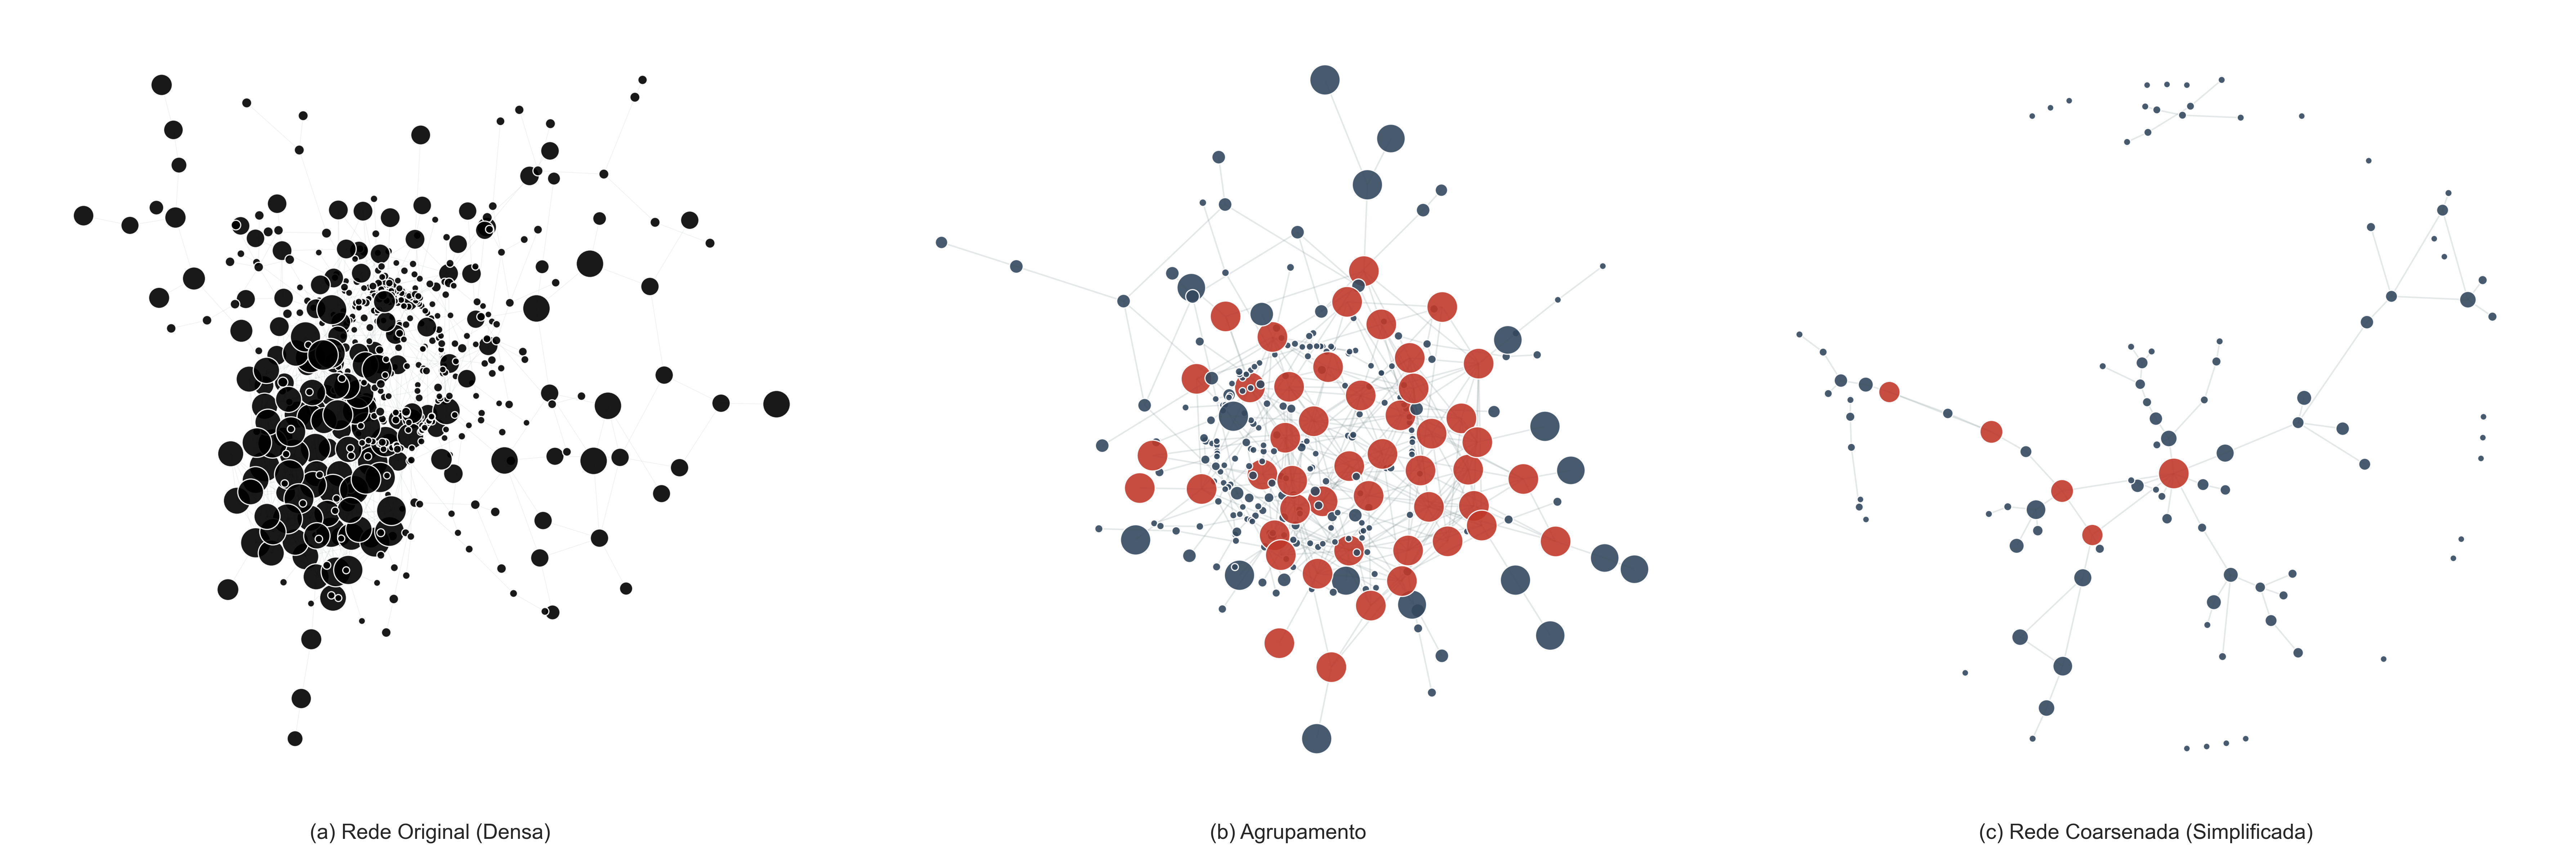

In [14]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import load_npz

# --- 1. CONFIGURAÇÃO ---
PATH_A_TRACKS = BASE_DIR / "graphs/item_item/A_tracks_adjacency.npz"
PATH_A_SUPER  = BASE_DIR / "graphs/super_item_item/A_super_tracks_adjacency.npz"

print("Carregando...")
A_tracks = load_npz(PATH_A_TRACKS)
A_super  = load_npz(PATH_A_SUPER)

# --- 2. FUNÇÕES DE ESTILO E FILTRAGEM ---

def get_backbone_subgraph(S, n_nodes=500, seed=42):
    """
    Cria um subgrafo focado em hubs e extrai a Árvore Geradora (Backbone)
    para evitar o visual de 'novelo de lã'.
    """
    # 1. Amostragem focada em nós de alto grau (Hubs)
    degrees = np.diff(S.indptr)
    # Pegamos os top N nós + alguns aleatórios para dar contexto
    top_indices = np.argsort(-degrees)[:n_nodes]
    
    # Recorte da matriz
    S_sub = S[top_indices, :][:, top_indices]
    
    # 2. Converter para NetworkX
    G = nx.from_scipy_sparse_array(S_sub)
    
    # 3. TRUQUE VISUAL: Extrair Maximum Spanning Tree (MST)
    # Isso força o grafo a parecer uma árvore/esqueleto limpo
    # Adicionamos um pouco de ruído aleatório aos pesos para a MST não ficar arbitrária em empates
    for u, v, d in G.edges(data=True):
        d['weight'] = d.get('weight', 1) + np.random.rand() * 0.01
        
    T = nx.maximum_spanning_tree(G, weight='weight')
    
    # Opcional: Adicionar de volta algumas arestas fortes que ficaram de fora da árvore
    # para não ficar "magro" demais (add 10% das arestas originais)
    remaining_edges = [e for e in G.edges(data=True) if not T.has_edge(e[0], e[1])]
    remaining_edges.sort(key=lambda x: x[2]['weight'], reverse=True)
    
    num_add = int(len(remaining_edges) * 0.05) # Adiciona 5% das arestas de volta
    T.add_edges_from(remaining_edges[:num_add])
    
    # Calcular graus no subgrafo para tamanho
    d = dict(G.degree()) # Usamos o grau do grafo cheio original para tamanho, fica mais bonito
    nx.set_node_attributes(T, d, 'degree')
    
    return T

def draw_skeleton_style(G, title, ax, highlight_hubs=False, seed=42):
    # Layout Kamada-Kawai é melhor para estruturas de árvore/esqueleto que o Spring
    # Se der erro (demorar), troque por nx.spring_layout(G, k=0.5, iterations=100)
    try:
        pos = nx.kamada_kawai_layout(G)
    except:
        pos = nx.spring_layout(G, k=0.3, seed=seed)
        
    # Tamanhos
    degrees = np.array([G.nodes[n].get('degree', 1) for n in G.nodes()])
    # Normalização forte para destacar hubs
    sizes = np.power(degrees, 1.8) 
    sizes = 20 + 400 * (sizes / (sizes.max() + 1e-9))
    
    # Cores
    if highlight_hubs:
        # Vermelho para Hubs (Top 5%), Cinza Azulado para o resto
        threshold = np.percentile(degrees, 95)
        node_colors = ["#c0392b" if d >= threshold else "#34495e" for d in degrees]
        edge_alpha = 0.2
        width = 1.0
    else:
        # Estilo "Poeira Cósmica" (Preto e Cinza)
        node_colors = "black"
        edge_alpha = 0.1
        width = 0.5
        
    # Desenhar
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=edge_alpha, width=width, edge_color="#7f8c8d")
    
    nx.draw_networkx_nodes(
        G, pos, 
        ax=ax, 
        node_size=sizes, 
        node_color=node_colors, 
        edgecolors="white", # Borda branca faz o nó "saltar"
        linewidths=0.8,
        alpha=0.9
    )
    
    ax.set_title(title, fontsize=14, y=-0.05)
    ax.axis('off')

# --- 3. EXECUÇÃO ---

print("Gerando esqueletos dos grafos...")

# Nível 1: Grafo Original (Mais denso, 600 nós)
G1 = get_backbone_subgraph(A_tracks, n_nodes=600, seed=1)

# Nível 2: Intermediário (Menos nós, estrutura clareando, 300 nós)
G2 = get_backbone_subgraph(A_tracks, n_nodes=300, seed=2)

# Nível 3: Coarsenado (Super-Nós, 100 nós para ficar bem limpo)
# Como A_super é pequeno, pegamos uma amostra menor ainda para enfatizar a redução
G3 = get_backbone_subgraph(A_super, n_nodes=100, seed=3)

# PLOT
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

draw_skeleton_style(G1, "(a) Rede Original (Densa)", ax=axes[0], highlight_hubs=False)
draw_skeleton_style(G2, "(b) Agrupamento", ax=axes[1], highlight_hubs=True) # Destaca hubs aqui
draw_skeleton_style(G3, "(c) Rede Coarsenada (Simplificada)", ax=axes[2], highlight_hubs=True)

plt.tight_layout()
plt.savefig(BASE_DIR / "reports/figures/fig_coarsening_skeleton.png", dpi=300, bbox_inches='tight')
plt.show()